# Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Caricamento del dataset
df = pd.read_csv('Datasets/atp_tennis.csv')

# Pre-elaborazione
# Rimuovere righe con valori mancanti (se presenti)
df = df.dropna()

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [3]:
# Creiamo nuove feature per ogni partita
df_matches = pd.DataFrame()

# 1. Differenza di ranking tra i giocatori
df_matches['ranking_diff'] = abs(df['Rank_1'] - df['Rank_2'])

# 2. Media ranking dei due giocatori
df_matches['avg_ranking'] = (df['Rank_1'] + df['Rank_2']) / 2

# 3. Differenza punti (se disponibili)
if 'Pts_1' in df.columns and 'Pts_2' in df.columns:
    df_matches['points_diff'] = abs(df['Pts_1'] - df['Pts_2'])
    df_matches['total_points'] = df['Pts_1'] + df['Pts_2']

# 4. Competitività della partita (basata sul punteggio)
def get_match_competitiveness(row):
    sets = row['Score'].split(' ')
    total_games = 0
    games_diff = 0
    for set_score in sets:
        if '-' in set_score:
            games = set_score.split('-')
            total_games += int(games[0]) + int(games[1])
            games_diff += abs(int(games[0]) - int(games[1]))
    return total_games, games_diff

df_matches[['total_games', 'games_diff']] = df.apply(get_match_competitiveness, axis=1, result_type='expand')

df_matches.describe()

,ranking_diff,avg_ranking,points_diff,total_points,total_games,games_diff
count,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000
mean,71.586733,74.617957,1344.508026,2961.847882,25.731135,7.059945
std,118.904843,73.819479,1988.353278,2812.322493,8.489996,2.903114
min,0.000000,1.500000,0.000000,7.000000,12.000000,2.000000
25%,18.000000,35.000000,253.000000,1365.000000,19.000000,5.000000
50%,40.000000,57.500000,610.000000,2001.500000,24.000000,7.000000
75%,78.000000,89.000000,1460.000000,3325.000000,31.000000,9.000000
max,4911.000000,2459.500000,16641.000000,25735.000000,183.000000,24.000000


In [7]:
from tqdm import tqdm
import time

print("Inizializzazione dell'elaborazione delle feature...")

# 1. Caratteristiche del torneo
print("\n1. Mappatura dei livelli dei tornei...")
df_matches['tournament_level'] = df['Series'].map({
    'Masters Cup': 5,
    'Masters 1000': 4,
    'ATP500': 3,
    'ATP250': 2,
    'International': 1
})
print("✓ Livelli dei tornei mappati")

# 2. Superficie e tipo di campo
print("\n2. Creazione delle variabili dummy per superficie e campo...")
print("- Elaborazione superficie...")
surface_dummies = pd.get_dummies(df['Surface'], prefix='surface')
print("- Elaborazione tipo di campo...")
court_dummies = pd.get_dummies(df['Court'], prefix='court')
print("- Concatenazione dei risultati...")
df_matches = pd.concat([df_matches, surface_dummies, court_dummies], axis=1)
print("✓ Variabili dummy create e concatenate")

# 3. Fase del torneo
print("\n3. Mappatura delle fasi del torneo...")
df_matches['tournament_round'] = df['Round'].map({
    '1st Round': 1,
    '2nd Round': 2,
    'Quarterfinals': 3,
    'Semifinals': 4,
    'The Final': 5
})
print("✓ Fasi del torneo mappate")

# 4. Stagionalità
print("\n4. Elaborazione della stagionalità...")
print("- Conversione date...")
df_matches['month'] = pd.to_datetime(df['Date']).dt.month
print("- Mappatura stagioni...")
df_matches['season'] = pd.to_datetime(df['Date']).dt.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})
print("✓ Stagionalità elaborata")

# 5. Quote e probabilità
print("\n5. Calcolo quote e probabilità...")
if 'Odd_1' in df.columns and 'Odd_2' in df.columns:
    print("- Calcolo rapporto quote...")
    df_matches['odds_ratio'] = df['Odd_1'] / df['Odd_2']
    print("- Calcolo differenza probabilità implicite...")
    df_matches['implied_prob_diff'] = abs((1/df['Odd_1']) - (1/df['Odd_2']))
    print("✓ Quote e probabilità calcolate")
else:
    print("⚠ Quote non disponibili nel dataset")

# 6. Analisi punteggio
print("\n6. Analisi dettagliata dei punteggi...")
def analyze_score(row):
    sets = row['Score'].split(' ')
    tiebreaks = sum(1 for set_score in sets if '7-6' in set_score or '6-7' in set_score)
    max_games_diff = max(abs(int(s.split('-')[0]) - int(s.split('-')[1])) 
                        for s in sets if '-' in s)
    total_sets = len(sets)
    return tiebreaks, max_games_diff, total_sets

print("- Elaborazione punteggi in corso...")
tqdm.pandas(desc="Analisi punteggi")
df_matches[['tiebreaks', 'max_games_diff', 'total_sets']] = \
    df.progress_apply(analyze_score, axis=1, result_type='expand')
print("✓ Analisi punteggi completata")

# 7. Statistiche storiche
print("\n7. Calcolo statistiche storiche dei giocatori...")
print("- Pre-processing delle date...")
df['Date'] = pd.to_datetime(df['Date'])

def get_player_stats(player_id, date):
    previous_matches = df[
        ((df['Player_1'] == player_id) | (df['Player_2'] == player_id)) &
        (df['Date'] < date)
    ]
    wins = len(previous_matches[previous_matches['Winner'] == player_id])
    total_matches = len(previous_matches)
    win_rate = wins / total_matches if total_matches > 0 else 0
    return win_rate, total_matches

print("- Calcolo statistiche Player 1...")
tqdm.pandas(desc="Statistiche Player 1")
df_matches['player1_win_rate'], df_matches['player1_experience'] = \
    zip(*df.progress_apply(lambda x: get_player_stats(x['Player_1'], x['Date']), axis=1))

print("- Calcolo statistiche Player 2...")
tqdm.pandas(desc="Statistiche Player 2")
df_matches['player2_win_rate'], df_matches['player2_experience'] = \
    zip(*df.progress_apply(lambda x: get_player_stats(x['Player_2'], x['Date']), axis=1))

print("✓ Statistiche storiche calcolate")

# 8. Indici finali
print("\n8. Calcolo indici di esperienza e forma...")
print("- Calcolo differenze di esperienza...")
df_matches['experience_diff'] = abs(df_matches['player1_experience'] - df_matches['player2_experience'])
print("- Calcolo differenze di forma...")
df_matches['form_diff'] = abs(df_matches['player1_win_rate'] - df_matches['player2_win_rate'])
print("✓ Indici calcolati")

print("\n✓ Elaborazione completata! Visualizzazione statistiche descrittive...\n")
df_matches.describe()

Inizializzazione dell'elaborazione delle feature...

1. Mappatura dei livelli dei tornei...
✓ Livelli dei tornei mappati

2. Creazione delle variabili dummy per superficie e campo...
- Elaborazione superficie...
- Elaborazione tipo di campo...
- Concatenazione dei risultati...
✓ Variabili dummy create e concatenate

3. Mappatura delle fasi del torneo...
✓ Fasi del torneo mappate

4. Elaborazione della stagionalità...
- Conversione date...
- Mappatura stagioni...
✓ Stagionalità elaborata

5. Calcolo quote e probabilità...
- Calcolo rapporto quote...
- Calcolo differenza probabilità implicite...
✓ Quote e probabilità calcolate

6. Analisi dettagliata dei punteggi...
- Elaborazione punteggi in corso...


Analisi punteggi: 100%|██████████| 48344/48344 [00:00<00:00, 99352.22it/s] 


✓ Analisi punteggi completata

7. Calcolo statistiche storiche dei giocatori...
- Pre-processing delle date...
- Calcolo statistiche Player 1...


Statistiche Player 1: 100%|██████████| 48344/48344 [03:20<00:00, 241.61it/s]


- Calcolo statistiche Player 2...


Statistiche Player 2: 100%|██████████| 48344/48344 [03:21<00:00, 240.11it/s]

✓ Statistiche storiche calcolate

8. Calcolo indici di esperienza e forma...
- Calcolo differenze di esperienza...
- Calcolo differenze di forma...
✓ Indici calcolati

✓ Elaborazione completata! Visualizzazione statistiche descrittive...



SyntaxError: 'return' outside function (2142899111.py, line 114)

In [8]:
df_matches.describe()

,ranking_diff,avg_ranking,points_diff,total_points,total_games,games_diff,tournament_level,tournament_round,month,odds_ratio,implied_prob_diff,tiebreaks,max_games_diff,total_sets,player1_win_rate,player1_experience,player2_win_rate,player2_experience,experience_diff,form_diff
count,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,35857.000000,43663.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000,48344.000000
mean,71.586733,74.617957,1344.508026,2961.847882,25.731135,7.059945,2.545919,1.801846,5.645478,1.876613,0.405293,0.466387,3.624504,2.613458,0.495858,184.832016,0.496074,186.496732,165.322667,0.156792
std,118.904843,73.819479,1988.353278,2812.322493,8.489996,2.903114,1.003878,1.017343,2.996074,2.924595,0.246416,0.656215,1.220109,0.759956,0.164521,190.288486,0.164653,192.796595,176.953675,0.132832
min,0.000000,1.500000,0.000000,7.000000,12.000000,2.000000,1.000000,1.000000,1.000000,0.019608,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,35.000000,253.000000,1365.000000,19.000000,5.000000,2.000000,1.000000,3.000000,0.473868,0.192498,0.000000,3.000000,2.000000,0.411271,43.000000,0.411765,44.000000,37.000000,0.056689
50%,40.000000,57.500000,610.000000,2001.500000,24.000000,7.000000,2.000000,2.000000,6.000000,1.000000,0.380952,0.000000,4.000000,2.000000,0.493687,123.000000,0.495264,123.000000,105.000000,0.124711
75%,78.000000,89.000000,1460.000000,3325.000000,31.000000,9.000000,3.000000,2.000000,8.000000,2.142857,0.590336,1.000000,5.000000,3.000000,0.597717,263.000000,0.598039,265.000000,231.000000,0.219064
max,4911.000000,2459.500000,16641.000000,25735.000000,183.000000,24.000000,5.000000,5.000000,12.000000,67.000000,1.000454,4.000000,10.000000,5.000000,1.000000,1193.000000,1.000000,1200.000000,1186.000000,1.000000


Preprocessing dei dati

In [9]:
# Gestione dei valori mancanti
df_matches = df_matches.fillna(df_matches.mean())

# Standardizzazione delle feature
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_matches)
df_matches_scaled = pd.DataFrame(features_scaled, columns=df_matches.columns)

TypeError: Could not convert ['SummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterWinterSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSpringSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerSummerFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFallFall'] to numeric

## Visualizzazione dei dati tramite distribuzioni e grafici

### Come sono distribuite le vittorie tra i giocatori?

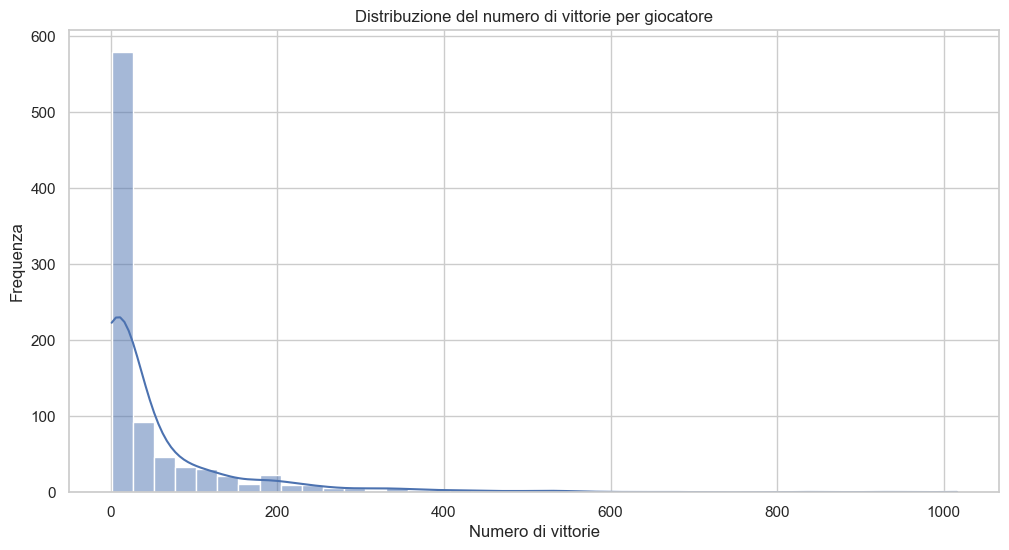

In [72]:
# 1. Distribuzione del numero di vittorie
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.histplot(data=vincitori['total_wins'], kde=True, bins=40)
plt.title('Distribuzione del numero di vittorie per giocatore')
plt.xlabel('Numero di vittorie')
plt.ylabel('Frequenza')
plt.show()

### La relazione tra ranking e vittorie

<Figure size 1800x1200 with 0 Axes>

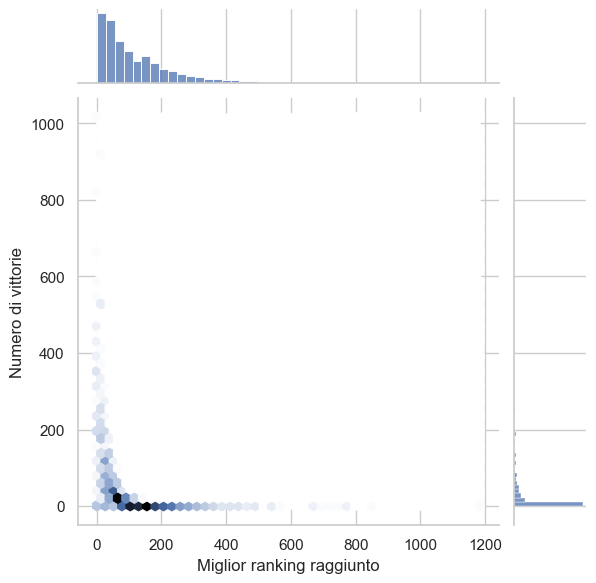

In [73]:
# 2. Relazione tra vittorie e ranking migliore
plt.figure(figsize=(18, 12))
sns.set_style('whitegrid')
sns.jointplot(data=vincitori, x='best_rank', y='total_wins', kind='hex')
plt.xlabel('Miglior ranking raggiunto')
plt.ylabel('Numero di vittorie')
plt.show()

### Come si distribuiscono le vittorie sulle diverse superfici

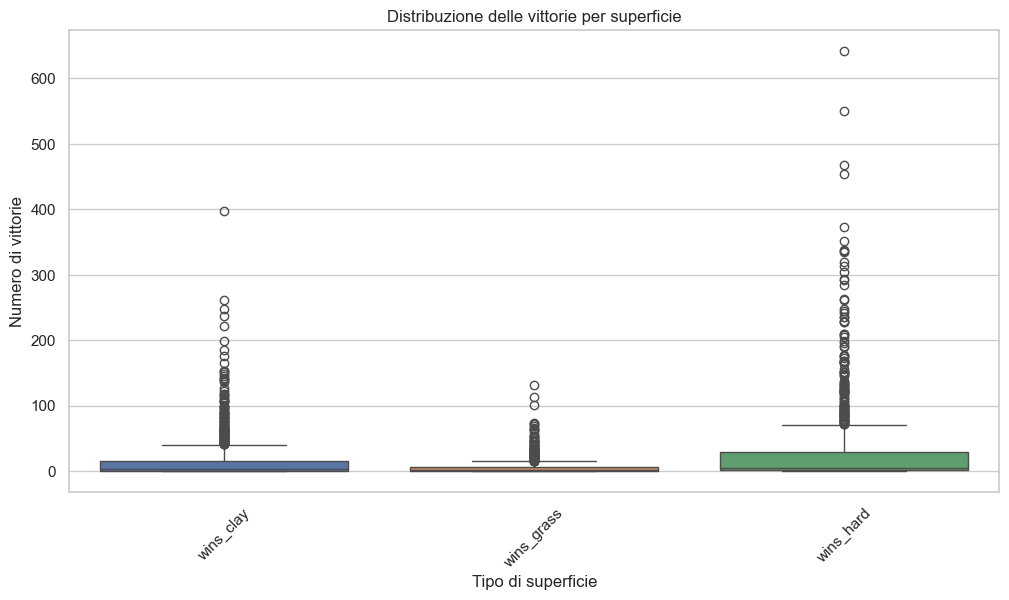

In [74]:
# 3. Distribuzione delle vittorie per superficie
surface_columns = [col for col in vincitori.columns if col.startswith('wins_')]
surface_data = vincitori[surface_columns]

plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.boxplot(data=surface_data)
plt.title('Distribuzione delle vittorie per superficie')
plt.xlabel('Tipo di superficie')
plt.ylabel('Numero di vittorie')
plt.xticks(rotation=45)
plt.show()

### Chi sono i giocatori più attivi?


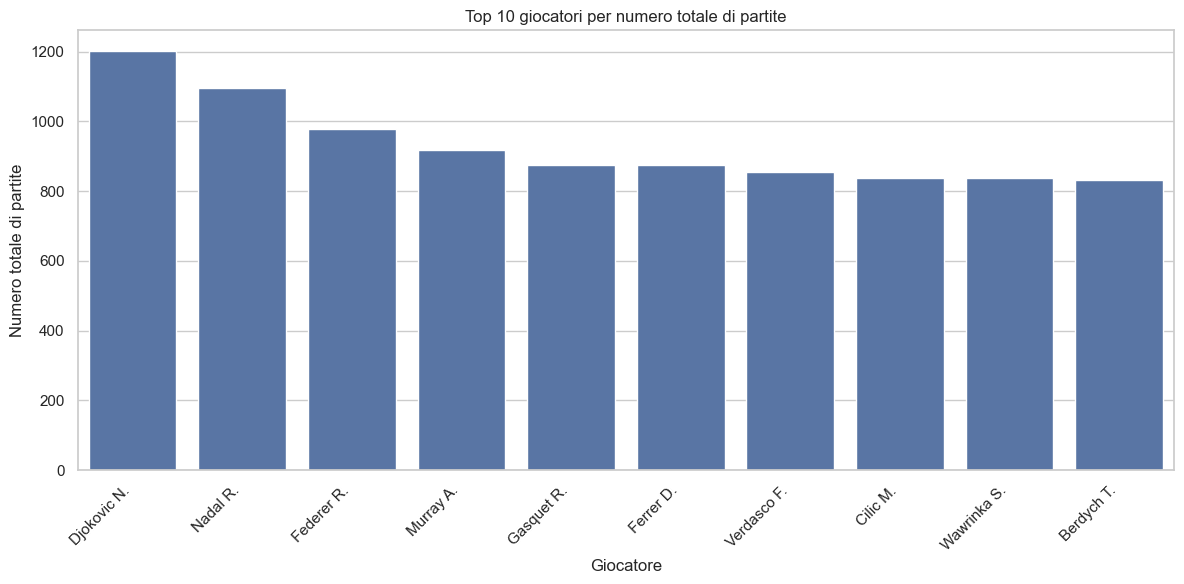

In [75]:
# 4. Top 10 giocatori per numero totale di partite
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
top_10_matches = vincitori.nlargest(10, 'total_matches')
sns.barplot(data=top_10_matches, x=top_10_matches.index, y='total_matches')
plt.title('Top 10 giocatori per numero totale di partite')
plt.xlabel('Giocatore')
plt.ylabel('Numero totale di partite')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Come sono correlate le diverse statistiche tra loro?

La matrice di correlazione è uno strumento molto utile per capire come le variabili del tuo dataset siano collegate tra loro. Essa mostra quanto due variabili siano correlate tra loro: se il valore della correlazione è vicino a 1, significa che c’è una forte correlazione positiva, se è vicino a -1, c’è una forte correlazione negativa, mentre un valore vicino a 0 indica che non c’è correlazione.

Passaggi per calcolare e visualizzare la matrice di correlazione:

1.	Calcolare la matrice di correlazione: Usiamo la funzione .corr() di Pandas, che calcola la correlazione tra le variabili numeriche nel DataFrame.
    
2.	Visualizzare la matrice di correlazione: Usiamo una heatmap per visualizzare la matrice, che rende più facile interpretare i valori di correlazione.

In [10]:
# sns.pairplot(): È una funzione di Seaborn che genera un pairplot, ovvero una matrice di grafici a dispersione tra tutte le coppie di colonne del DataFrame. 
# Inoltre, genera anche istogrammi lungo la diagonale per mostrare la distribuzione di ciascuna variabile.

sns.pairplot(df_matches)
plt.show()

ValueError: Data must be 1-dimensional, got ndarray of shape (48344, 2) instead

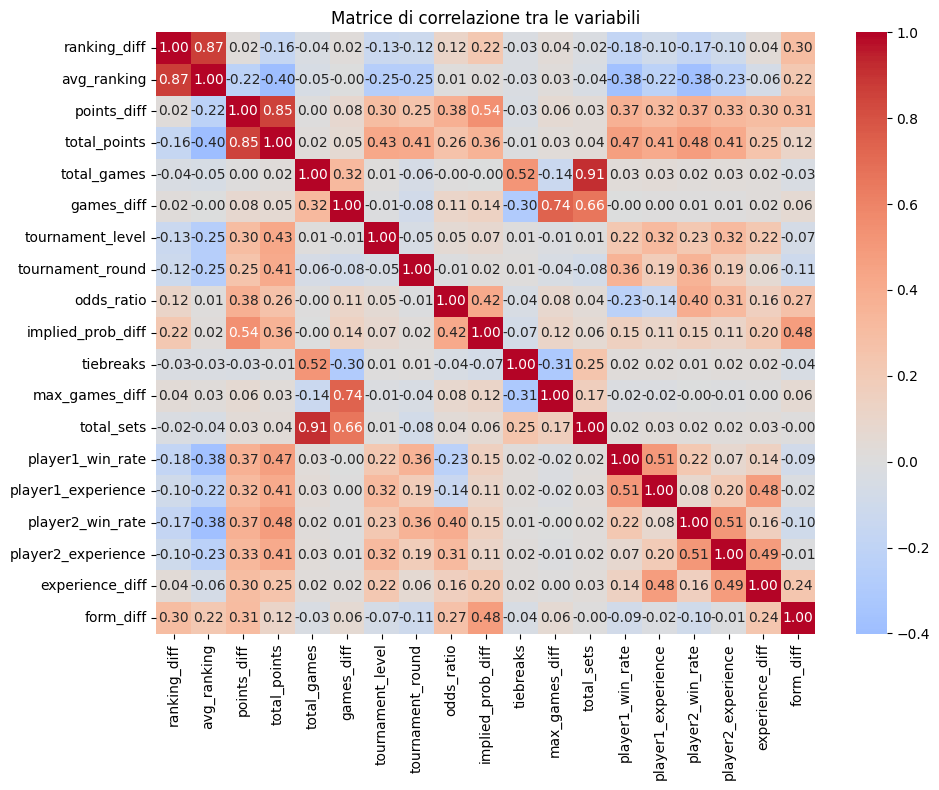

In [11]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_matches.select_dtypes(include=['float64', 'int64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0)
plt.title('Matrice di correlazione tra le variabili')
plt.tight_layout()
plt.show()

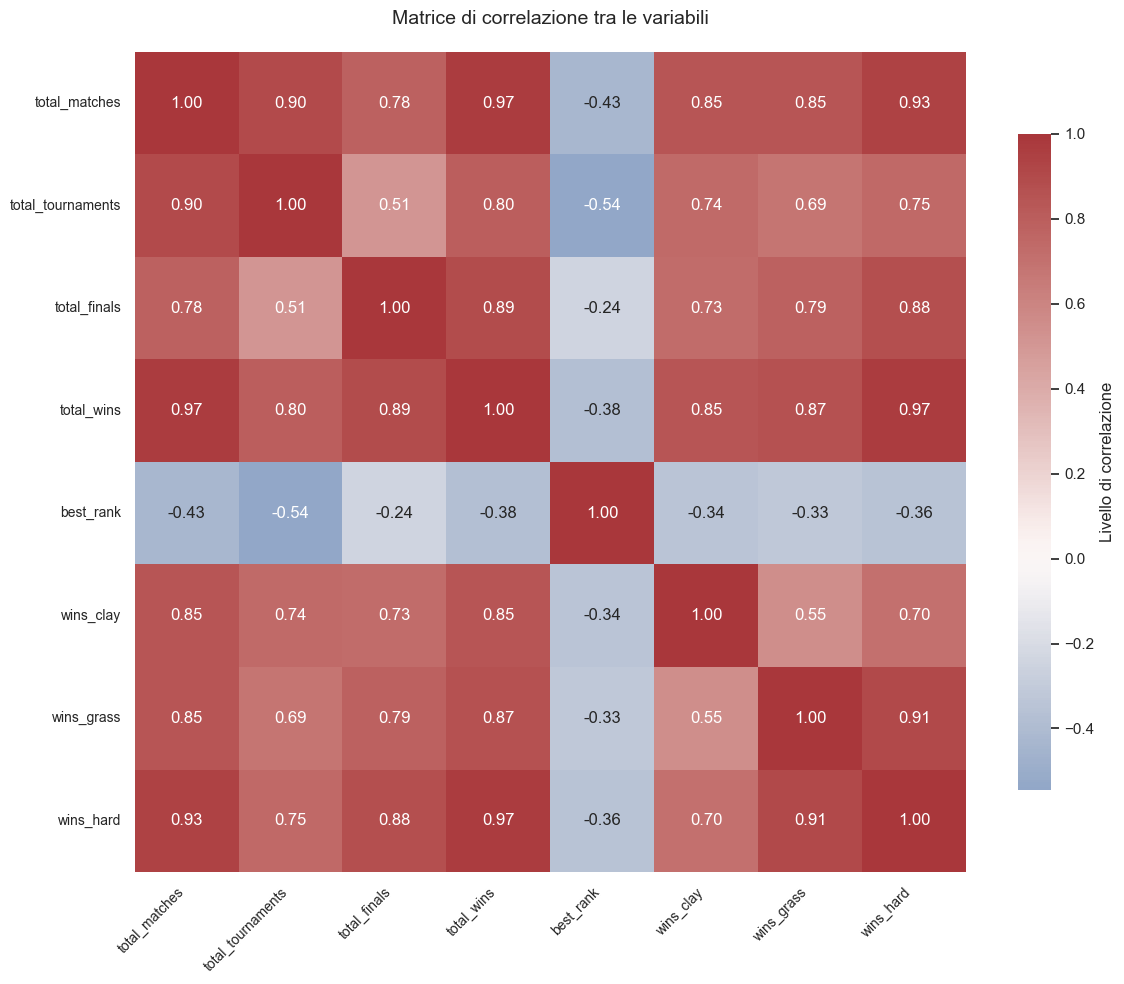

In [56]:
# Visualizzazione diversamente brutta

import matplotlib.pyplot as plt
import seaborn as sns

# Creazione della figura
plt.figure(figsize=(12, 10))

# Calcolo della matrice di correlazione
correlation_matrix = vincitori.select_dtypes(include=['float64', 'int64']).corr()

# Creazione della heatmap
sns.heatmap(
    correlation_matrix,
    annot=True,            # Mostra i valori numerici
    cmap='vlag',           # Colormap con maggior contrasto
    fmt='.2f',             # Formato dei numeri (2 cifre decimali)
    center=0,              # Centra i colori intorno a 0
    cbar_kws={'shrink': 0.8, 'label': 'Livello di correlazione'}  # Personalizza la color bar
)

# Miglioramento dell'aspetto
plt.xticks(rotation=45, ha='right', fontsize=10)  # Ruota e ridimensiona i tick dell'asse X
plt.yticks(fontsize=10)                           # Ridimensiona i tick dell'asse Y
plt.title('Matrice di correlazione tra le variabili', fontsize=14, pad=20)  # Titolo con padding
plt.tight_layout()

# Mostra il grafico
plt.show()

La PCA (Principal Component Analysis) è una tecnica di riduzione della dimensionalità che consente di ridurre il numero di variabili, mantenendo la maggior parte dell’informazione (varianza) del dataset originale. PCA trova delle combinazioni lineari delle variabili originali chiamate componenti principali che spiegano la maggior parte della varianza nel dataset.

Quando hai un dataset con molte feature correlate, come nel tuo caso, la PCA ti permette di ridurre il numero di variabili senza perdere informazioni cruciali, migliorando l’efficienza computazionale e la comprensibilità del modello.

Passaggi per applicare PCA:

1.	Preparare i dati: È importante normalizzare i dati prima di applicare la PCA, poiché PCA è sensibile alla scala delle variabili.

2.	Applicare PCA: Usare PCA di Scikit-learn per ridurre il numero di componenti.

3.	Scegliere il numero di componenti: Decidere quante componenti principali mantenere. Generalmente si mantiene abbastanza componenti per spiegare una percentuale significativa della varianza (ad esempio, l’80% della varianza).

Codice per applicare la PCA:

1.	Normalizzazione dei Dati: Prima di applicare PCA, bisogna normalizzare i dati (ridurre i valori a una scala comune).

2.	Applicazione della PCA: Dopo aver normalizzato i dati, possiamo applicare la PCA e ridurre il numero di componenti.

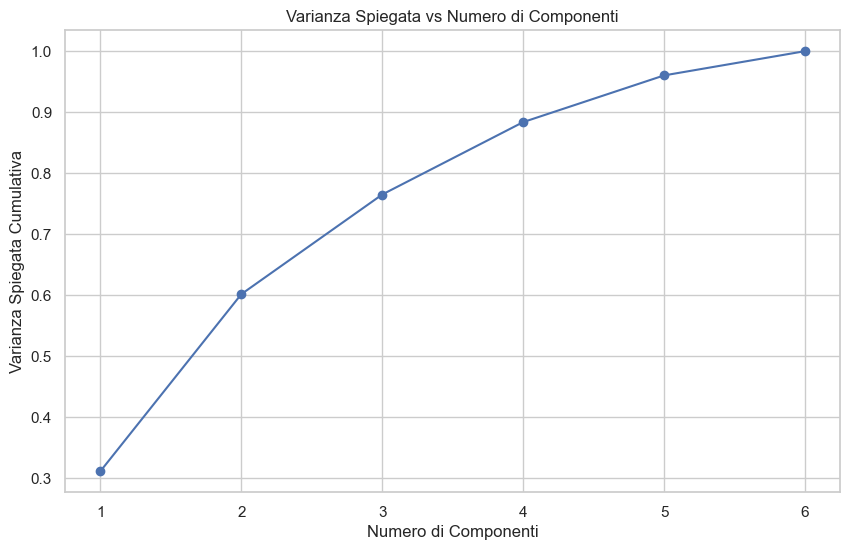


Varianza spiegata da ogni componente:
Componente 1: 0.312 (31.2%)
Componente 2: 0.290 (29.0%)
Componente 3: 0.163 (16.3%)
Componente 4: 0.119 (11.9%)
Componente 5: 0.077 (7.7%)
Componente 6: 0.040 (4.0%)

Matrice dei componenti principali:
       Rank_1    Rank_2     Pts_1     Pts_2     Odd_1     Odd_2
PC1 -0.328561  0.303090  0.376708 -0.344629 -0.511122  0.527504
PC2 -0.301807 -0.323670  0.547246  0.567622  0.317557  0.285717
PC3  0.583226  0.583516  0.126514  0.116342  0.379734  0.381597
PC4 -0.617862  0.633573 -0.249119  0.274991  0.186132 -0.210964
PC5 -0.265893 -0.230689 -0.419876 -0.414605  0.523833  0.503477
PC6 -0.091400  0.090832  0.551589 -0.545878  0.429729 -0.443277


In [61]:
# Preparazione dei dati per PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Selezione delle features numeriche per PCA
features_for_pca = ['Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2']
X = df[features_for_pca]

# Standardizzazione dei dati
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applicazione PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Visualizzazione della varianza spiegata
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'bo-')
plt.xlabel('Numero di Componenti')
plt.ylabel('Varianza Spiegata Cumulativa')
plt.title('Varianza Spiegata vs Numero di Componenti')
plt.grid(True)
plt.show()

# Stampa della varianza spiegata per ogni componente
print("\nVarianza spiegata da ogni componente:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"Componente {i+1}: {var:.3f} ({var*100:.1f}%)")

# Matrice dei componenti
componenti_df = pd.DataFrame(
    pca.components_,
    columns=features_for_pca,
    index=[f'PC{i+1}' for i in range(len(pca.components_))]
)

print("\nMatrice dei componenti principali:")
print(componenti_df)